In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/1936_march_10"


/content/drive/MyDrive/1936_march_10


In [4]:


!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-kl15tbjt
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-kl15tbjt
  Resolved https://github.com/facebookresearch/detectron2.git to commit 2c6c380f94a27bd8455a39506c9105f652b9f760
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 85.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filen

In [5]:
# to display images inline
%matplotlib inline

# import some common libraries
import cv2
import random
import glob
import os
import shutil
import json
import math
import numpy as np
import matplotlib.pyplot as plt

# import detectron2, etc.
import detectron2
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [6]:
# cd into the dataset
print(os.getcwd())

# we now register the dataset
register_coco_instances("1936_march_10_train", {}, "train.json", ".")
register_coco_instances("1936_march_10_test", {}, "test.json", ".")
register_coco_instances("1936_march_10_combined", {}, "result.json", ".")


/content/drive/MyDrive/1936_march_10


WARNING [05/22 11:40:14 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/22 11:40:14 d2.data.datasets.coco]: Loaded 14 images in COCO format from train.json
./images/c5a9b3a6-00000001.tif.large.jpg
./images/ccd0a1dc-00000012.tif.large.jpg
./images/dfefd7c8-00000002.tif.large.jpg
./images/9befd628-00000018.tif.large.jpg
./images/f70d63b1-00000014.tif.large.jpg


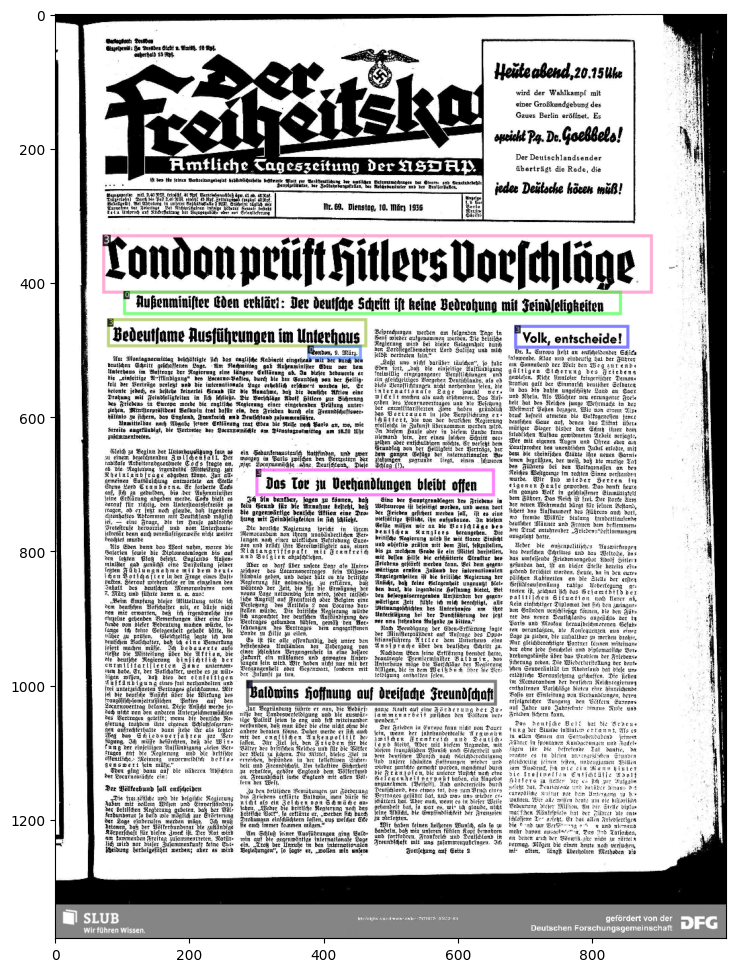

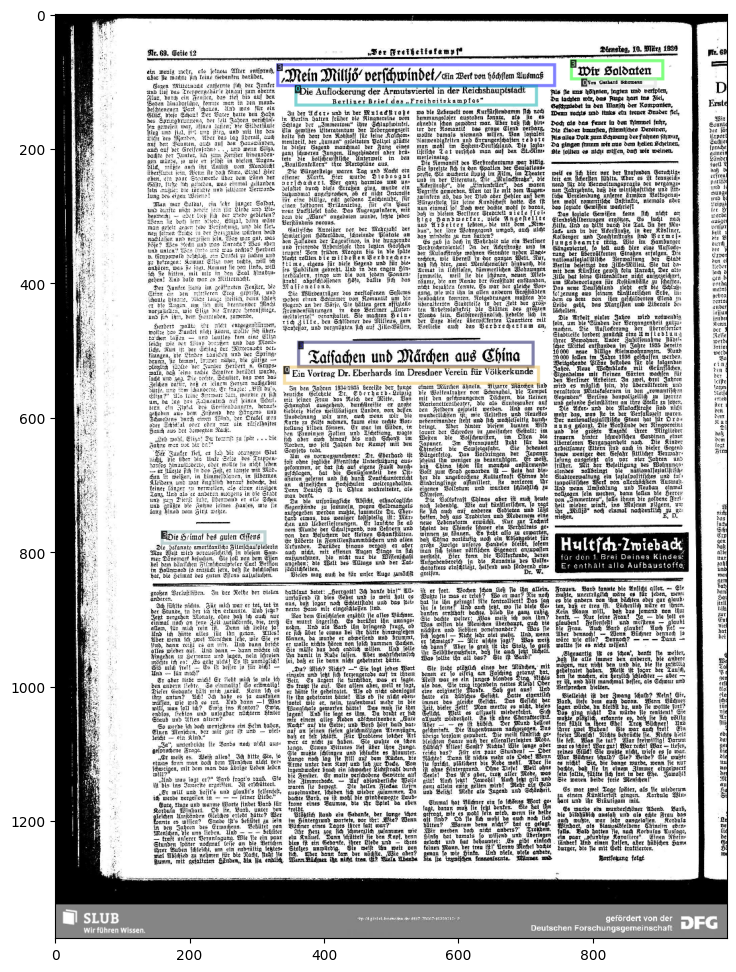

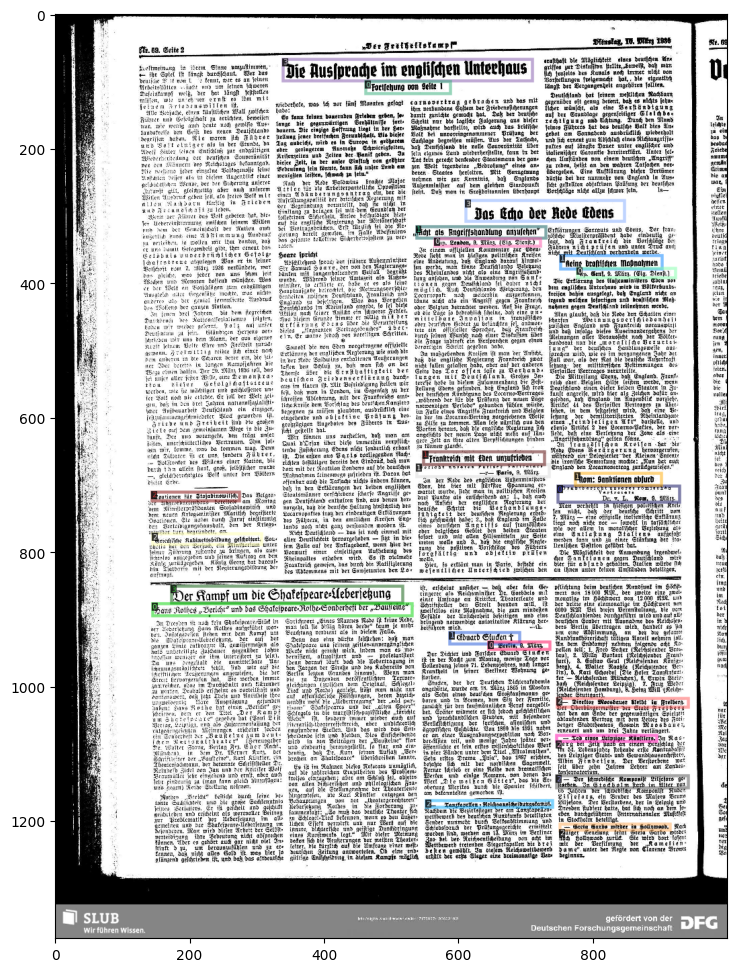

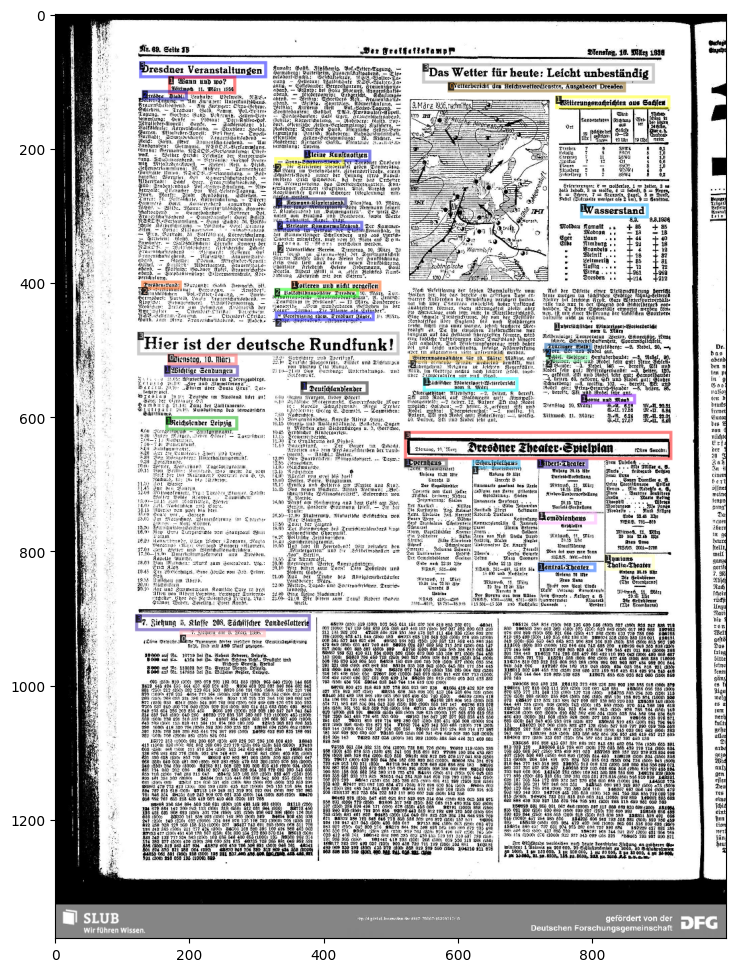

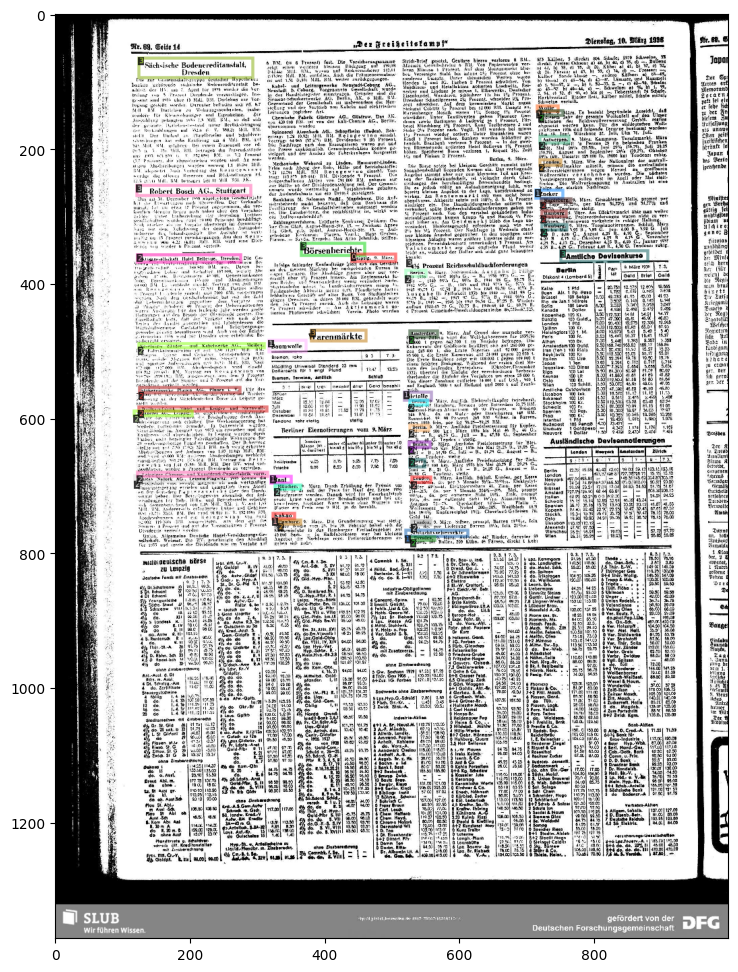

In [7]:
# sets random seed for reproducibility
random.seed(0)

dataset_dicts = DatasetCatalog.get("1936_march_10_train")
my_metadata = MetadataCatalog.get("1936_march_10_test")

# print some examples of the annotated data.
n_examples_to_display = 5
for d in random.sample(dataset_dicts, n_examples_to_display):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_metadata, scale=0.5)
    v = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(15,12))
    plt.imshow(v.get_image()[:, :, ::-1])

In [8]:
# sets batch size
batch_size = 16
# sets epoch size accordingly (to convert iterations to epochs)
epoch = math.ceil(2748/float(batch_size))
# sets total number of epochs to train for
epoch_num = 10

cfg = get_cfg()
# loads in correct pre-trained model parameters
cfg.merge_from_file("fast_rcnn_R_50_FPN_3x.yaml")
# loads pre-trained model weights (from Model Zoo)
cfg.MODEL.WEIGHTS = "model_final_280758.pkl"
# loads in training/val data using the registered COCO instance
cfg.DATASETS.TRAIN = ("1936_march_10_train",)
cfg.DATASETS.TEST = ("1936_march_10_test",)
# sets number of object classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7

# makes output directory for weights, etc.
os.makedirs("model_weights/", exist_ok=True)

# sets output directory for model weights, checkpoints, etc.
cfg.OUTPUT_DIR = 'model_weights/'

# some hyperparameters
cfg.SOLVER.BASE_LR = 0.00025
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.SOLVER.MAX_ITER = epoch
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.MODEL.DEVICE = "cuda"

In [9]:
print("EPOCH 1")


# trains for one epoch
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)  #change here if resuming
trainer.train()

######## FOR SAVING MODEL WEIGHTS AFTER EACH EPOCH TO AN S3 BUCKET #########
# with open("../model_weights/model_final.pth", "rb") as f:
#     s3.upload_fileobj(f, "BUCKET-NAME-HERE", "new_val_model_weights/model_epoch_1.pth")
############################################################################

# evaluates on validation data after one epoch
# metrics are printed out to console
trainer.test(trainer.cfg, trainer.model, COCOEvaluator("1936_march_10_test", trainer.cfg, False, trainer.cfg.OUTPUT_DIR))

######## FOR SAVING PREDICTIONS ON VALIDATION SET AFTER EACH EPOCH TO AN S3 BUCKET ########
# with open("../model_weights/coco_instances_results.json", "rb") as f:
#     s3.upload_fileobj(f, "BUCKET-NAME-HERE", "new_val_model_weights/coco_results_epoch_1.json")
###########################################################################################

# trains then evaluates on validation data iteratively for desired number of epochs
for i in range(0, epoch_num-1):
    
    print("EPOCH " + str(i+2))

    # trains again
    cfg.SOLVER.MAX_ITER = epoch*(i+2)
    trainer = DefaultTrainer(cfg) 
    trainer.resume_or_load(resume=True)
    trainer.train()
    
    ######## FOR SAVING MODEL WEIGHTS AFTER EACH EPOCH TO AN S3 BUCKET #########
#     with open("../model_weights/model_final.pth", "rb") as f:
#         s3.upload_fileobj(f, "BUCKET-NAME-HERE", "new_val_model_weights/model_eopch_" + str(i+2) + ".pth")
    ############################################################################   
    
    trainer.test(trainer.cfg, trainer.model, COCOEvaluator("1936_march_10_test", trainer.cfg, False, trainer.cfg.OUTPUT_DIR))

    ######## FOR SAVING PREDICTIONS ON VALIDATION SET AFTER EACH EPOCH TO AN S3 BUCKET ########
#     with open("../model_weights/coco_instances_results.json", "rb") as f:
#         s3.upload_fileobj(f, "BUCKET-NAME-HERE", "new_val_model_weights/coco_results_epoch_" + str(i+2) + ".json")
    ###########################################################################################


EPOCH 1
[05/22 11:40:46 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
  

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[05/22 11:40:48 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/22 11:41:44 d2.utils.events]:  eta: 0:05:57  iter: 19  total_loss: 6.019  loss_cls: 2.074  loss_box_reg: 0.1183  loss_rpn_cls: 3.195  loss_rpn_loc: 0.6196    time: 2.5093  last_time: 2.3622  data_time: 0.9725  last_data_time: 0.6615   lr: 2.7839e-05  max_mem: 9810M
[05/22 11:42:39 d2.utils.events]:  eta: 0:05:13  iter: 39  total_loss: 3.047  loss_cls: 1.68  loss_box_reg: 0.7202  loss_rpn_cls: 0.2593  loss_rpn_loc: 0.4324    time: 2.5354  last_time: 2.3761  data_time: 0.8476  last_data_time: 0.7026   lr: 5.6879e-05  max_mem: 9810M
[05/22 11:43:28 d2.utils.events]:  eta: 0:04:25  iter: 59  total_loss: 2.41  loss_cls: 1.036  loss_box_reg: 0.7093  loss_rpn_cls: 0.2156  loss_rpn_loc: 0.3859    time: 2.5092  last_time: 2.4146  data_time: 0.7708  last_data_time: 0.6927   lr: 8.592e-05  max_mem: 9810M
[05/22 11:44:21 d2.utils.events]:  eta: 0:03:42  iter: 79  total_loss: 2.107  loss_cls: 0.891  loss_box_reg: 0.7225  loss_rpn_cls: 0.1608  loss_rpn_loc: 0.3454    time: 2.5463  last_time: 2.7

KeyboardInterrupt: ignored